In [256]:
import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import rasterio

In [257]:
dataset = "AMAZON"
root_dir = os.path.join("/home/lck/Schreibtisch/", dataset)

In [258]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [259]:
# define model for Amazondataset
model_amazon = smp.PAN(
    encoder_name = 'resnet101',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    ).to(device)

# set model to evaluation mode
model_amazon.eval()

# simple prediction function
def predict(md,image, threshold=0.5):
    model = md
    with torch.no_grad():
        output = model(image)           # [1, 1, H, W]
        pred = (output> threshold).float()

    return pred.squeeze().cpu().numpy()

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model_amazon.parameters(), lr=0.0001) #optimizer

In [260]:
def plot_metrics(metrics):
    """
    Plot training and validation metrics to evaluate model performance.

    Args:
        metrics (dict): Dictionary containing training and validation metrics
                       collected during training.

    Plots:
        - Training and Validation Loss over epochs
        - Validation IoU and Dice over epochs
        - Validation Precision, Recall, and Accuracy over epochs
    """
    import matplotlib.pyplot as plt

    # Calculate additional metrics from tp, fp, tn, fn
    tp = metrics['val']['tp_per_epoch']
    fp = metrics['val']['fp_per_epoch']
    tn = metrics['val']['tn_per_epoch']
    fn = metrics['val']['fn_per_epoch']

    # Precision = TP / (TP + FP)
    precision = [t / (t + f + 1e-7) for t, f in zip(tp, fp)]
    # Recall = TP / (TP + FN)
    recall = [t / (t + f + 1e-7) for t, f in zip(tp, fn)]
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = [(t + n) / (t + n + f + g + 1e-7) for t, n, f, g in zip(tp, tn, fp, fn)]

    epochs = list(range(1, len(metrics['train']['avg_loss_per_epoch']) + 1))

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Training Metrics', fontsize=16, fontweight='bold')

    # Subplot 1: Loss
    axes[0, 0].plot(epochs, metrics['train']['avg_loss_per_epoch'], label='Train Loss', color='blue', linewidth=2, marker='o')
    axes[0, 0].plot(epochs, metrics['val']['avg_loss_per_epoch'], label='Val Loss', color='red', linewidth=2, marker='s')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Subplot 2: IoU
    axes[0, 1].plot(epochs, metrics['val']['iou_per_epoch'], label='IoU', color='green', linewidth=2, marker='^')
    axes[0, 1].set_title('Validation IoU')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Subplot 3: Dice
    axes[0, 2].plot(epochs, metrics['val']['dice_per_epoch'], label='Dice', color='purple', linewidth=2, marker='d')
    axes[0, 2].set_title('Validation Dice')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Dice')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Subplot 4: Precision
    axes[1, 0].plot(epochs, precision, label='Precision', color='orange', linewidth=2, marker='x')
    axes[1, 0].set_title('Validation Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Subplot 5: Recall
    axes[1, 1].plot(epochs, recall, label='Recall', color='cyan', linewidth=2, marker='v')
    axes[1, 1].set_title('Validation Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Subplot 6: Accuracy
    axes[1, 2].plot(epochs, accuracy, label='Accuracy', color='magenta', linewidth=2, marker='*')
    axes[1, 2].set_title('Validation Accuracy')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [261]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, num_classes=1, plot_results=True, patience=5, monitor_metric='val_loss'):
    """
    Train the model with early stopping.
    
    Args:
        model: The model to train.
        criterion: Loss function.
        optimizer: Optimizer.
        num_epochs: Maximum number of epochs.
        train_loader: Training data loader.
        val_loader: Validation data loader.
        device: Device to train on.
        num_classes: Number of classes (for future use).
        plot_results: Whether to plot results (not implemented yet).
        patience: Number of epochs to wait for improvement before stopping.
        monitor_metric: Metric to monitor for early stopping ('val_loss', 'iou', 'dice').
    """
    
    metrics = {
        "train": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": []
        },
        "val": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": [],
            "iou_per_epoch": [],
            "dice_per_epoch": [],
            "tp_per_epoch": [],
            "fp_per_epoch": [],
            "tn_per_epoch": [],
            "fn_per_epoch": []
        }
    }

    # Early Stopping Variablen
    best_metric = float('inf') if monitor_metric == 'val_loss' else 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # ===== TRAINING =====
        model.train()
        epoch_train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader, 1):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            metrics["train"]["loss_per_batch"].append(loss.item())
            print(f"  Train batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        metrics["train"]["avg_loss_per_epoch"].append(avg_train_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        tpsum, tnsum, fpsum, fnsum = 0.0, 0.0, 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loader, 1):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                # Get metrics
                epoch_val_loss += loss.item()
                tp, fp, fn, tn = smp.metrics.get_stats((outputs > 0.5).long().squeeze(1), masks.long().squeeze(1), mode='binary')

                # safe metrics
                tpsum += tp.sum().item()
                tnsum += tn.sum().item()
                fpsum += fp.sum().item()
                fnsum += fn.sum().item()

                print(
                    f"  Val batch {batch_idx}/{len(val_loader)} | "
                    f"Loss: {loss.item():.4f}"
                )
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        dice_epoch = (2 * tpsum) / (2 * tpsum + fpsum + fnsum + 1e-7)
        iou = tpsum / (tpsum + fpsum + fnsum + 1e-7)
        
        metrics["val"]["avg_loss_per_epoch"].append(avg_val_loss)
        metrics["val"]["iou_per_epoch"].append(iou)
        metrics["val"]["dice_per_epoch"].append(dice_epoch)
        metrics["val"]["tp_per_epoch"].append(tpsum)
        metrics["val"]["tn_per_epoch"].append(tnsum)
        metrics["val"]["fp_per_epoch"].append(fpsum)
        metrics["val"]["fn_per_epoch"].append(fnsum)

        print(
            f"\nEpoch Summary:"
            f"\n  Train Loss: {avg_train_loss:.4f}"
            f"\n  Val Loss:   {avg_val_loss:.4f}"
            f"\n  Val IoU:    {iou:.4f}"
            f"\n  Val Dice:   {dice_epoch:.4f}"
        )

        # Early Stopping Check
        current_metric = {
            'val_loss': avg_val_loss,
            'iou': iou,
            'dice': dice_epoch
        }[monitor_metric]

        if monitor_metric == 'val_loss':
            improved = current_metric < best_metric
        else:
            improved = current_metric > best_metric

        if improved:
            print(f"  -> Improvement in {monitor_metric}: {current_metric - best_metric:.4f}")
            best_metric = current_metric
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # Speichere besten Zustand
        else:
            patience_counter += 1
            print(f"  -> No improvement in {monitor_metric} for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement in {monitor_metric} for {patience} epochs).")
            break

    # Lade das beste Modell zurück
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model state.")

    torch.save(model.state_dict(), "forest_model_final.pth")
    print("\nTraining finished.")

    if(plot_results):
        plot_metrics(metrics)

    return metrics, model

In [262]:
import rasterio
class AmazonDataset(Dataset):
    def __init__(self, root_dir=root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(os.path.join(root_dir, "image")))
        self.masks = sorted(os.listdir(os.path.join(root_dir, "label")))
        self.transform = transform
        self.mask_transform = mask_transform

        print(f" #images == #masks = {len(self.images) == len(self.masks)}")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_dir = os.path.join(self.root_dir, "image")
        mask_dir = os.path.join(self.root_dir, "label")

        with rasterio.open(os.path.join(image_dir, self.images[index])) as src:
            image = src.read()
            image = (image / 10000 * 255).astype(np.uint8)  # Skalierung für PIL
        with rasterio.open(os.path.join(mask_dir, self.masks[index])) as src:
            mask = src.read()
            mask = mask.astype(np.float32).squeeze(0)  # (1, H, W) -> (H, W), Float32

        if self.transform:
            image = np.moveaxis(image, 0, -1)  # (4, H, W) -> (H, W, 4)
            image = self.transform(Image.fromarray(image))

        if self.mask_transform:
            mask = self.mask_transform(Image.fromarray(mask.astype(np.uint8)))  # Zu uint8 für PIL, dann transform
            mask = (mask > 0).long()  # Sicherstellen, dass es binär 0.0 oder 1.0 ist
           
        return image, mask

In [263]:
mean = torch.tensor([0.485, 0.456, 0.406, 0.5])
std  = torch.tensor([0.229, 0.224, 0.225, 0.5])
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Separate Transform für Masken (binär, nearest Interpolation um Daten zu erhalten)
mask_preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()  # Konvertiert zu Float-Tensor (0-1)
])

In [264]:
train_data_amazon = AmazonDataset(os.path.join(root_dir, "Training"), transform=preprocess, mask_transform=mask_preprocess)
val_data_amazon = AmazonDataset(os.path.join(root_dir, "Validation"), transform=preprocess, mask_transform=mask_preprocess)

 #images == #masks = True
 #images == #masks = True


In [265]:
train_loader_amazon = DataLoader(train_data_amazon, batch_size=8, shuffle=True, pin_memory=True)
val_loader_amazon = DataLoader(val_data_amazon, batch_size=8, shuffle=False, pin_memory=True)


Epoch [1/50]
  Train batch 1/63 | Loss: 0.5261
  Train batch 2/63 | Loss: 0.4196
  Train batch 3/63 | Loss: 0.3998
  Train batch 4/63 | Loss: 0.4861
  Train batch 5/63 | Loss: 0.3241
  Train batch 6/63 | Loss: 0.3652
  Train batch 7/63 | Loss: 0.3141
  Train batch 8/63 | Loss: 0.3451
  Train batch 9/63 | Loss: 0.3692
  Train batch 10/63 | Loss: 0.3977
  Train batch 11/63 | Loss: 0.2967
  Train batch 12/63 | Loss: 0.3110
  Train batch 13/63 | Loss: 0.3030
  Train batch 14/63 | Loss: 0.4728
  Train batch 15/63 | Loss: 0.3935
  Train batch 16/63 | Loss: 0.3726
  Train batch 17/63 | Loss: 0.3475
  Train batch 18/63 | Loss: 0.3186
  Train batch 19/63 | Loss: 0.3058
  Train batch 20/63 | Loss: 0.4774
  Train batch 21/63 | Loss: 0.4125
  Train batch 22/63 | Loss: 0.2751
  Train batch 23/63 | Loss: 0.3384
  Train batch 24/63 | Loss: 0.4515
  Train batch 25/63 | Loss: 0.3697
  Train batch 26/63 | Loss: 0.3653
  Train batch 27/63 | Loss: 0.3808
  Train batch 28/63 | Loss: 0.4048
  Train batch 2

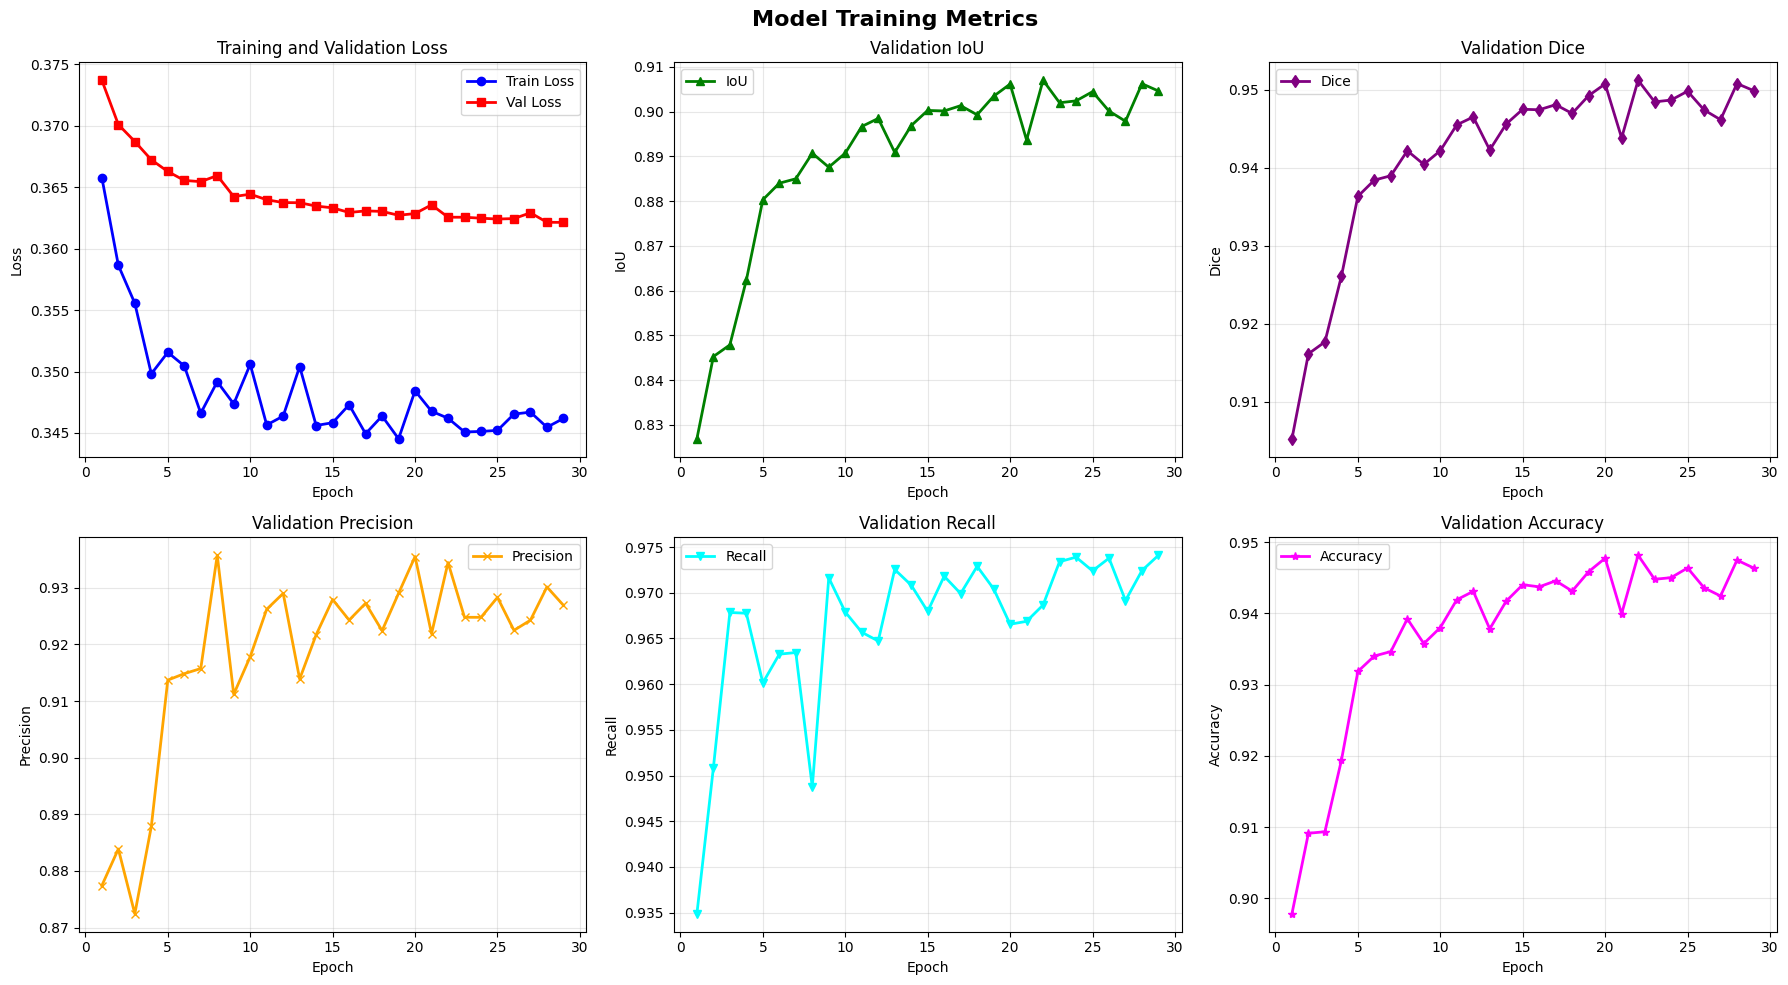

In [266]:
val_metrics, trained_model = train_model(model_amazon, criterion, optimizer, 50, train_loader_amazon, val_loader_amazon, device, patience=7, monitor_metric='iou')

 #images == #masks = True


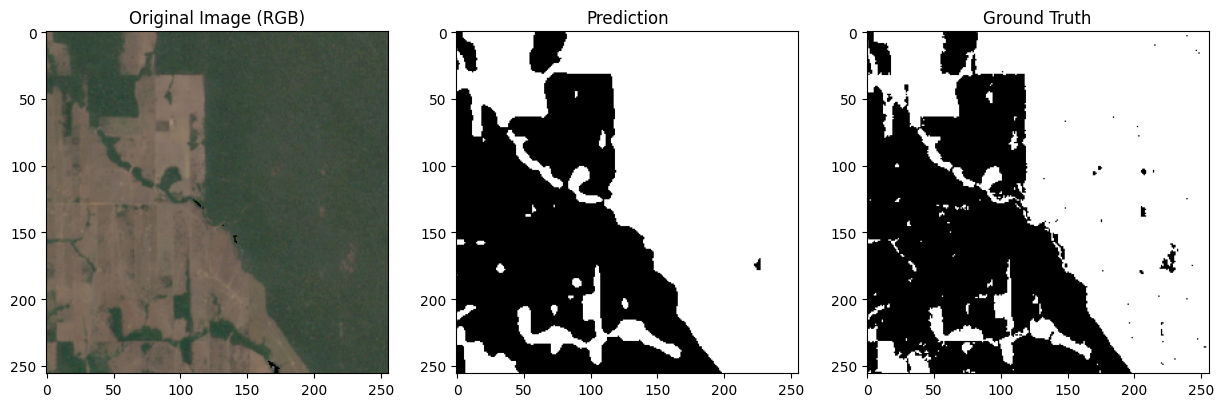

In [270]:
i = 13

test_data_amazon = AmazonDataset(os.path.join(root_dir, "Test"), transform=preprocess, mask_transform=mask_preprocess)
preds = predict(model_amazon, test_data_amazon[i][0].unsqueeze(0).to(device))

plt.figure(figsize=(15,5))  # Korrigiert: figure statt Figure
img, mask = test_data_amazon[i]
plt.subplot(1,3,1)
img_to_plot = img.permute(1,2,0).cpu().numpy()  # Auf CPU und numpy
# Denormalisieren: Rückgängigmachen der Normalisierung
img_to_plot = img_to_plot * np.array([0.229, 0.224, 0.225, 0.5]) + np.array([0.485, 0.456, 0.406, 0.5])
img_to_plot = np.clip(img_to_plot, 0, 1)
img_to_plot = np.power(img_to_plot, 0.4)
plt.imshow(img_to_plot[:, :, :3])  # Nur RGB-Kanäle (0-2), ignoriere 4. Kanal
plt.title("Original Image (RGB)")

plt.subplot(1,3,2)
plt.imshow(preds, cmap='gray')
plt.title("Prediction")

plt.subplot(1,3,3)
plt.imshow(mask.squeeze(0).cpu().numpy(), cmap='gray')
plt.title("Ground Truth")

plt.show()